In [ ]:
# !pip install tensorflow==2.4.1

In [2]:
# COLAB ONLY
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD

from multiprocessing.pool import ThreadPool
from multiprocessing import Pool 
from scipy.stats import ks_2samp

# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier

In [4]:
print(tf.__version__)

2.4.1


In [5]:
# Data loading
folder_path = '/content/drive/MyDrive/Data/colabs_data/WiDS' #Kaggle: ../input/widsdatathon2021/ #Local PC: '.'
df_train = pd.read_csv(folder_path + "/TrainingWiDS2021.csv")
df_test = pd.read_csv(folder_path + "/UnlabeledWiDS2021.csv")
print(df_train.shape)
print(df_test.shape)

(130157, 181)
(10234, 180)


In [6]:
# Data type 
# ['hospital_id']
col_target = 'diabetes_mellitus'
cols_id = ['encounter_id', 'Unnamed: 0']
cols_cat = [i for i in df_train.select_dtypes('object').columns if i not in cols_id + [col_target]]
cols_num = [i for i in df_train if i not in cols_cat + cols_id + [col_target] ]
cols_ft = cols_cat + cols_num

In [7]:
df_ft_full = pd.concat( [df_train[cols_ft], df_test[cols_ft]], axis = 0)
df_ft_full[cols_num] = df_ft_full[cols_num].fillna(0)
df_ft_full[cols_cat] = df_ft_full[cols_cat].fillna('missing')
# df_ft_full = df_ft_full.reset_index(drop = True)
    
# df_ft_full[cols_cat] = df_ft_full[cols_cat].astype('object')
# df_ft_full[cols_num] = df_ft_full[cols_num].astype('float64')

In [34]:
i = cols_cat[0]
df_analytics = df_train[ [i, col_target]]
x = df_analytics.groupby(i).agg({col_target: lambda x: np.sum(x)/len(x), i:lambda x: len(x)/df_analytics.shape[0]})
x.columns = ['p', 'q']

In [46]:
df_train[cols_cat + [col_target]]

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,diabetes_mellitus
0,Caucasian,M,Floor,Floor,admit,CTICU,1
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,1
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU,0
4,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU,0
...,...,...,...,...,...,...,...
130152,Caucasian,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU,0
130153,Caucasian,F,Direct Admit,Accident & Emergency,admit,MICU,0
130154,African American,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU,1
130155,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0


In [206]:
def evaluate_binary_cross_entropy(df, target_col):
    cols_ = [i for i in df.columns if i != target_col ]
    ce_list = {}
    for col in cols_:
        x = df[ [col, target_col] ].groupby(col).agg({target_col: lambda x: np.sum(x)/len(x), col:lambda x: len(x)/df.shape[0]}).dropna()
        x.columns = ['p', 'q']
        ce = -sum([x.iloc[i,:]['p']*np.log2(x.iloc[i,:]['q']) for i in range(len(x))])
        ce_list[col] = ce 
    return ce_list

ce_dict = evaluate_binary_cross_entropy(df_train[cols_cat + [col_target]], col_target)

In [207]:
def evaluate_num_bce(df, target_col, bin = 100):
    '''evaluate binary cross entropy of the numeric data'''
    cols_ = [i for i in df.columns if i != target_col ]
    ce_list = {}
    df = df.copy()
    for col in cols_:
        df[col] = pd.cut(df[col], bin)
    return evaluate_binary_cross_entropy(df, target_col)

ce_num_list = evaluate_num_bce(df_train[cols_num + [col_target]], col_target)

In [208]:
ce_num_df = pd.DataFrame.from_dict(ce_num_list, orient='index', columns = ['cross_entropy'])
ce_num_df.sort_values('cross_entropy', ascending= 0 )[:50]#.plot(kind = 'bar')

,cross_entropy
h1_glucose_max,562.101266
h1_glucose_min,556.925293
d1_glucose_max,438.629296
h1_creatinine_max,428.792447
glucose_apache,420.934034
h1_creatinine_min,419.743942
h1_bun_min,362.396261
h1_bun_max,361.328645
creatinine_apache,333.886917
d1_creatinine_max,331.850815


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


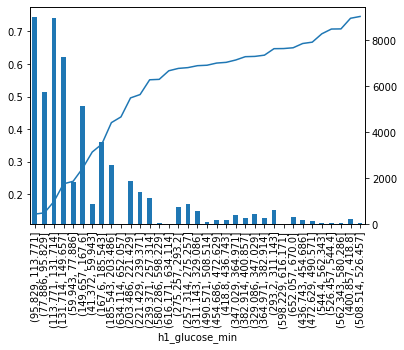

In [212]:
col = 'h1_glucose_min'
x = df_train[[col, col_target]]
x[col] = pd.cut(x[col], 35)
x = x.groupby(col).agg({col_target: lambda x: np.sum(x)/len(x), col:lambda x: len(x)})
x.columns = ['target_ratio', 'freq']
x = x.sort_values(by = 'target_ratio')
ax = x['target_ratio'].plot()
x['freq'].plot(kind = 'bar', ax = ax, secondary_y = True)

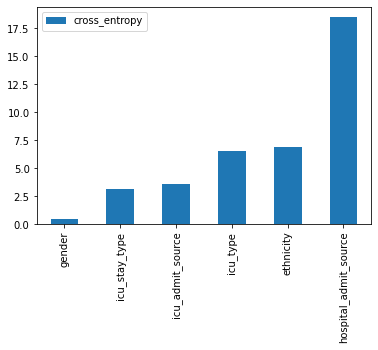

In [73]:
ce_df = pd.DataFrame.from_dict(ce_dict, orient='index', columns = ['cross_entropy'])
ce_df.sort_values('cross_entropy').plot(kind = 'bar')

evaluate at: ethnicity


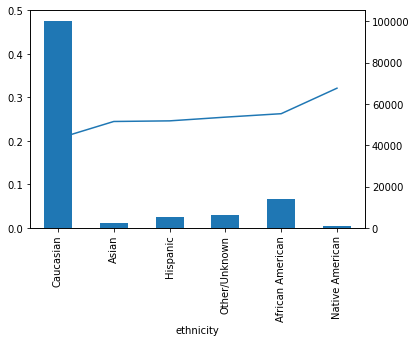

evaluate at: gender


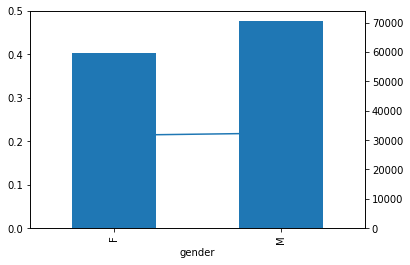

evaluate at: hospital_admit_source


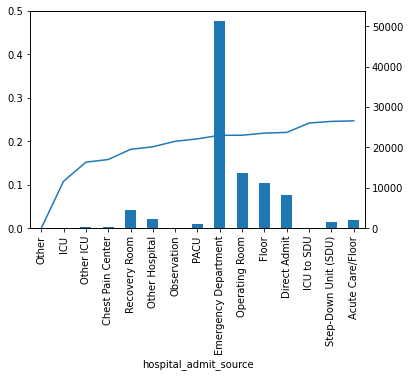

evaluate at: icu_admit_source


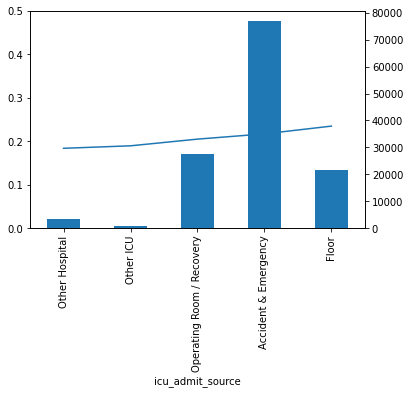

evaluate at: icu_stay_type


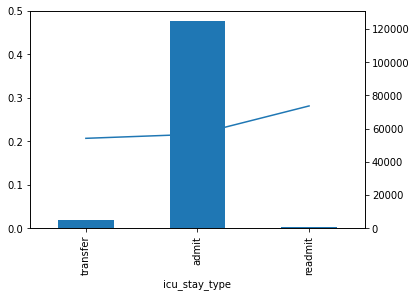

evaluate at: icu_type


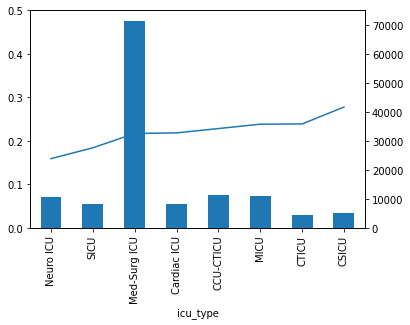

In [119]:
for col in cols_cat:
  print('evaluate at:', col)
  x = df_train[[col, col_target]].groupby(col).agg({col_target: lambda x: np.sum(x)/len(x), col:lambda x: len(x)})
  x.columns = ['target_ratio', 'freq']
  x = x.sort_values(by = 'target_ratio')
  ax = x['target_ratio'].plot(ylim = [0, 0.5])
  x['freq'].plot(kind = 'bar', ax = ax, secondary_y = True)
  plt.show()

In [130]:
col = 'hospital_admit_source'
x = df_train[[col, col_target]].groupby(col).agg({col_target: [lambda x: np.sum(x)/len(x), 'sum', 'count']})
x

diabetes_mellitus              
                             <lambda_0>    sum  count
hospital_admit_source                                
Acute Care/Floor               0.247020    518   2097
Chest Pain Center              0.158103     40    253
Direct Admit                   0.220405   1819   8253
Emergency Department           0.213801  10959  51258
Floor                          0.218827   2478  11324
ICU                            0.108108      4     37
ICU to SDU                     0.241935     15     62
Observation                    0.200000      2     10
Operating Room                 0.213927   2943  13757
Other                          0.000000      0      7
Other Hospital                 0.187422    453   2417
Other ICU                      0.151943     43    283
PACU                           0.205626    212   1031
Recovery Room                  0.181460    828   4563
Step-Down Unit (SDU)           0.245800    395   1607

## DATA SHIFTING CHECK
Dùng kiểm định Kolmogorov–Smirnov test để kiểm tra phân phối train/ test có giống nhau

In [171]:
ks_2samp(df_train['bmi'].dropna(), df_test['bmi'].dropna())

Ks_2sampResult(statistic=0.011720708543274228, pvalue=0.1887183965912331)

In [182]:
dict_ks_results = {col: ks_2samp(df_train[col].dropna(), df_test[col].dropna()) for col in cols_ft}
df_ks_results = pd.DataFrame.from_dict(dict_ks_results, orient='index', columns = ['statistics','p_value'])

In [165]:
ks_2samp(df_train['bmi'], df_test['bmi'])

Ks_2sampResult(statistic=0.06976350875623338, pvalue=1.5551539785395718e-40)

In [190]:
df_train[['d1_calcium_min']].describe()

,d1_calcium_min
count,113465.000000
mean,8.164674
std,0.793055
min,5.500000
25%,7.700000
50%,8.200000
75%,8.700000
max,10.300000


In [191]:
df_test[['d1_calcium_min']].describe()

,d1_calcium_min
count,8832.00000
mean,8.07449
std,0.80178
min,5.50000
25%,7.60000
50%,8.10000
75%,8.60000
max,10.20000


In [185]:
df_ks_results.sort_values('p_value', ascending=1).iloc[:30]

,statistics,p_value
hospital_id,1.000000,0.000000e+00
icu_id,0.050877,9.313698e-22
d1_calcium_min,0.051252,4.032510e-19
d1_calcium_max,0.051023,5.919929e-19
pre_icu_los_days,0.044067,1.984008e-16
age,0.037635,4.593853e-12
d1_diasbp_max,0.037171,8.703297e-12
d1_diasbp_noninvasive_max,0.036632,2.522367e-11
d1_mbp_max,0.035363,1.075999e-10
d1_mbp_noninvasive_max,0.034804,3.330286e-10


In [ ]:
df_train_full = pd.concat( [df_ft_full[:130157],df_train[[col_target]] ], axis = 1 )

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=128):
    dataframe = dataframe.copy()
    try:
        labels = dataframe.pop(col_target)
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    except:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
                                                
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    
    # For performance turning
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
batch_size = 1024 # A small batch sized is used for demonstration purposes

df_to_train, df_to_val = train_test_split(df_train_full, test_size = 0.2, shuffle=True)

ds_train = df_to_dataset(df_to_train, batch_size=batch_size)
ds_val = df_to_dataset(df_to_val, shuffle=False, batch_size=batch_size)
ds_test = df_to_dataset(df_ft_full[130157:], shuffle=False, batch_size=batch_size)

In [ ]:
# Check data is correct
for feature_batch, label_batch in ds_train.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['gender'])
    print('A batch of targets:', label_batch )

Every feature: ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'hospital_id', 'age', 'bmi', 'elective_surgery', 'height', 'icu_id', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_max', 

In [ ]:
# FEATURE COLUMNS
fcs_num = [tf.feature_column.numeric_column(i) for i in cols_num]
fcs_cat = [
    tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            col, vocabulary_list = list(df_ft_full[col].drop_duplicates() )
        ), dimension = int(len(df_ft_full[col].drop_duplicates() ) * 0.9)
    )
    for col in cols_cat
]


In [ ]:
# MLP Nets
model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(fcs_num ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.015), 
              metrics = [tf.keras.metrics.AUC()])

In [ ]:
history = model.fit( ds_train, validation_data = ds_val,
                   epochs = 10, batch_size = 128)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
102/102 [==============================] - ETA: 0s - loss: 0.6802 - auc: 0.6688WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'ethnicity': <tf.Tensor 'ExpandDims_77:0' shape=(None, 1) dtype=string>, 'gender': <tf.Tensor 'ExpandDims_83:0' shape=(None, 1) dtype=string>, 'hospital_admit_source': <tf.Tensor 'ExpandDims_153:0' shape=(None, 1) dtype=string>, 'icu_admit_source': <tf.Tensor 'ExpandDims_155:0' shape=(None, 1) dtype=string>, 'icu_stay_type': <tf.Tensor 'ExpandDims_157:0' shape=(None, 1) dtype=string>, 'icu_type': <tf.Tensor 'ExpandDims_158:0' shape=(None, 1) dtype=string>, 'hospital_id': <tf.Tensor 'ExpandDims_154:0' shape=(None, 1) dtype=int64>, 'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'bmi': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'ele

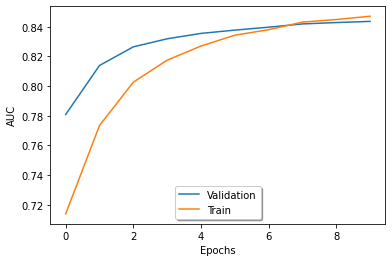

In [ ]:
# Exam results
plt.figure()
plt.ylabel("AUC")
plt.xlabel("Epochs")
# plt.ylim([0,2])
plt.plot(history.history['val_auc'],label='Validation')
plt.plot(history.history['auc'], label='Train')
plt.legend(loc='lower center', shadow=True, fontsize='medium')

### TURNING

In [ ]:
def get_permutation_importance_multiprocessing(model, dataframe, k = 5 , batch_size = 2048, target_col = 'target', metrix_index = 0):
  '''Get permutation feature importance
    * model: model đã được fit
    * k:int: số lần shuffle lại => tăng độ chính xác và giảm tính ngẫu nhiên
    * target_col: str: tên cột target
    * metrix_index: int: thứ tự (từ 0) metrix đánh giá trong số các metrix model cho phép '''
  ds = df_to_dataset( dataframe, shuffle=False, batch_size=batch_size)
  s0 = model.evaluate(ds)[metrix_index] # <-- Model được thiết lập với: 0: loss; 1: AUC
  cols_ft = [i for i in dataframe.columns if i != target_col]
    
  def eval_multiprocessing(col):
    s_i = []
    df_copy = dataframe.copy()
    for i in range(k):  
      df_copy[col] = df_copy[col].sample(frac = 1, random_state = i )
      ds = df_to_dataset( df_copy, shuffle=False, batch_size=batch_size)
      s_i.append( model.evaluate(ds)[metrix_index] )
    return s0 - sum(s_i)/len(s_i) 

  # DÙng ThreadPool để chạy song song 8 columns trong 1 lần => tăng tốc (dùng mp.Pool bị lỗi nên phải dùng ThreadPool)
  with ThreadPool(8) as pool:
    feature_importance = pool.map(lambda col: eval_multiprocessing( col ), cols_ft)
  return dict(zip(cols_ft,feature_importance)) 

fts_importance = get_permutation_importance_multiprocessing(model ,df_to_train, k=5,target_col = col_target, metrix_index = 1 )

13/51 [======>.......................] - ETA: 51s - loss: 0.3751 - auc: 0.8653

In [ ]:
df_fti = pd.DataFrame.from_dict(fts_importance , orient='index', columns = ['dloss'])
df_fti['dl_abs'] = df_fti['dloss'].abs()
df_fti.sort_values(by ='dl_abs', ascending=False).head(50)['dloss'].sort_values().plot(kind='barh', figsize=(10, 15))

## PREDICT FINAL SUBMISSION

In [ ]:
df_test['diabetes_mellitus'] = model.predict(ds_test)

In [ ]:
df_ss = df_test[['encounter_id', 'diabetes_mellitus']]
df_ss.to_csv('./submission.csv', index = False)